In [1]:
from bitwise_network import *
from binarized_network import *
from binary_layers import *
from datasets.two_source_mixture import *
from datasets.sinusoidal_data import *
from datasets.binary_data import *
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import scipy.signal as signal
from bss_eval import *
import IPython.display as ipd
import soundfile as sf
import mir_eval

%load_ext autoreload
%autoreload 2

# Binary Neural Network

In [2]:
def evaluate(binary_sample, raw_sample, model=None):
    mix, targ = raw_sample['mixture'], raw_sample['target']
    mix_mag, mix_phase = stft(mix)
    inter = mix - targ
    
    if model:
        bmag = torch.tensor(binary_sample['bmag'], dtype=torch.float)
        ibm = torch.tensor(binary_sample['ibm'], dtype=torch.float) 
        bmag = bmag.unsqueeze(0) 
        premask = model(2*bmag-1)
        premask = premask.squeeze(0)
        mask = make_binary_mask(premask.detach().numpy(), dtype=np.float)
        estimate = istft(mask*mix_mag, mix_phase)
        estimate = estimate / np.max(estimate)
    else:
        ibm = binary_sample['ibm']
        estimate = istft(ibm * mix_mag, mix_phase)
        mask = None

    # calculate bss eval metrics
    estimates = np.stack([estimate, inter], axis=0)
    sources = np.stack([targ, inter], axis=0)
    metrics = mir_eval.separation.bss_eval_sources(sources, estimates)
    metrics = BSSMetrics(metrics[0][0], metrics[1][0], metrics[2][0])
    # sources = np.stack([targ, inter], axis=1).T
    # metrics = bss_eval(estimate, sources)

    return metrics, estimate, mask, ibm

def run_evaluation(binary_dataset, raw_dataset, model=None):
    bss_metrics = BSSMetricsList()
    for i in range(len(binary_dataset)):
        binary_sample = binary_dataset[i]
        raw_sample = raw_dataset[i]
        metric, _, _, _ = evaluate(binary_sample, raw_sample, model)
        bss_metrics.append(metric)
            
    sdr, sir, sar = bss_metrics.mean()
    print('Mean SDR %f' % sdr)
    print('Mean SIR %f' % sir)
    print('Mean SAR %f'% sar)
    return bss_metrics
    
def get_audio_output(binary_sample, raw_sample, model=None):
    _, estimate, _, _ = evaluate(binary_sample, raw_sample, model)    
    print('Mixture')
    ipd.display(ipd.Audio(raw_sample['mixture'], rate=16000))
    print('Estimate')
    ipd.display(ipd.Audio(estimate, rate=16000))
    
def visualize_mask(binary_sample, raw_sample, model=None):
    _, _, mask, ibm = evaluate(binary_sample, raw_sample, model)
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(ibm, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(mask, cmap='binary')
    
def visualize_input(binary_sample, num_bits=4):
    bmag, ibm = binary_sample['bmag'], binary_sample['ibm']
    qmag = np.zeros((bmag.shape[0] // num_bits, bmag.shape[1]))
    for i in range(bmag.shape[0] // num_bits):
        for j in range(num_bits):
            qmag[i] += 2**(num_bits - j - 1) * bmag[num_bits*i + j]
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.pcolormesh(qmag, cmap='binary')
    plt.subplot(122)
    plt.pcolormesh(ibm, cmap='binary')

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 19.201391
Mean SIR 29.049108
Mean SAR 19.735770


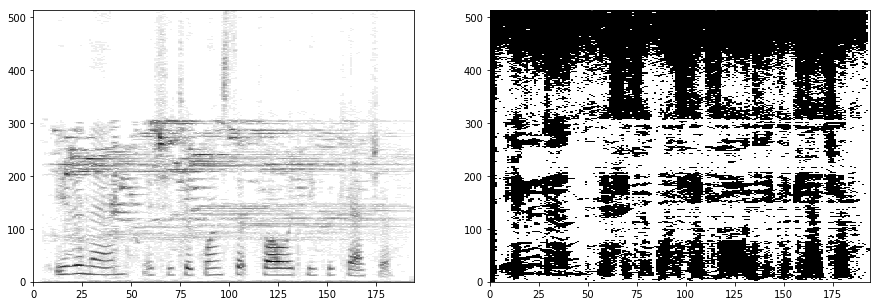

In [3]:
# Toy Dataset
toy_binary_set = BinaryDataset('/media/data/binary_audio/toy_val')
with open('/media/data/binary_audio/toy_val/dataset.pkl', 'rb') as f:
    toy_raw_set = pkl.load(f)
visualize_input(toy_binary_set[0])
run_evaluation(toy_binary_set, toy_raw_set)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 15.606398
Mean SIR 23.995619
Mean SAR 16.398320


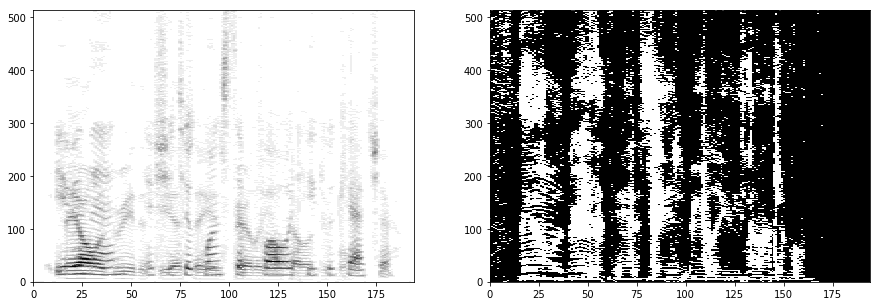

In [4]:
# Real Dataset
binary_set = BinaryDataset('/media/data/binary_audio/val')
with open('/media/data/binary_audio/val/dataset.pkl', 'rb') as f:
    raw_set = pkl.load(f)
visualize_input(binary_set[2])
run_evaluation(binary_set, raw_set)

## Bitwise Neural Network Evaluation

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 14.168474
Mean SIR 23.966528
Mean SAR 14.754261


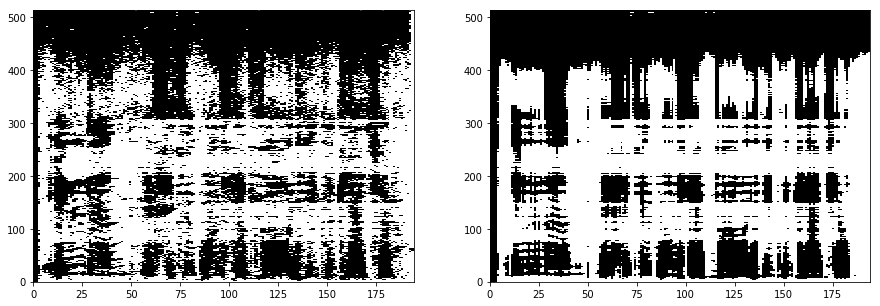

In [4]:
# Toy real network
toy_nn = BitwiseNetwork(2052, 513, fc_sizes=[1024, 1024])
toy_nn.eval()
toy_nn.load_state_dict(torch.load('models/toy_real_network.model'))
run_evaluation(toy_binary_set, toy_raw_set, toy_nn)
visualize_mask(toy_binary_set[0], toy_raw_set[0], toy_nn)
visualize_mask(toy_binary_set[0], toy_raw_set[0], toy_nn)
visualize_mask(toy_binary_set[100], toy_raw_set[100], toy_nn)
get_audio_output(toy_binary_set[0], toy_raw_set[0], toy_nn)
get_audio_output(toy_binary_set[100], toy_raw_set[100], toy_nn)

In [7]:
# Toy bitwise network
toy_bnn = BitwiseNetwork(2052, 513, fc_sizes=[1024, 1024])
toy_bnn.load_state_dict(torch.load('models/toy_bitwise_network.model'))
toy_bnn.inference()
toy_bnn.eval()
run_evaluation(toy_binary_set, toy_raw_set, toy_bnn)
visualize_mask(toy_binary_set[0], toy_raw_set[0], toy_nn)
visualize_mask(toy_binary_set[100], toy_raw_set[100], toy_nn)
get_audio_output(toy_binary_set[0], toy_raw_set[0], toy_nn)
get_audio_output(toy_binary_set[100], toy_raw_set[100], toy_nn)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 13.493169
Mean SIR 24.863236
Mean SAR 13.906994


In [6]:
# Evaluate real network
nn = BitwiseNetwork(2052, 513, fc_sizes=[2048, 2048])
nn.eval()
nn.load_state_dict(torch.load('models/real_network.model'))
bss_metrics = run_evaluation(binary_set, raw_set, nn)
visualize_mask(binary_set[0], raw_set[0], nn)
visualize_mask(binary_set[1], raw_set[1], nn)
get_audio_output(binary_set[0], raw_set[0], nn)
get_audio_output(binary_set[1], raw_set[1], nn)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 8.836217
Mean SIR 14.779202
Mean SAR 10.625049


In [8]:
# Evaluate bitwise network
bnn = BitwiseNetwork(2052, 513, fc_sizes=[2048, 2048])
bnn.load_state_dict(torch.load('models/bitwise_network.model'))
bnn.inference()
bnn.eval()
run_evaluation(binary_set, raw_set, bnn)
visualize_mask(binary_set[0], raw_set[0], bnn)
visualize_mask(binary_set[1], raw_set[1], bnn)
get_audio_output(binary_set[0], raw_set[0], bnn)
get_audio_output(binary_set[1], raw_set[1], bnn)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 7.350534
Mean SIR 13.080113
Mean SAR 9.343989


## Binarized Networks

In [5]:
bin_net = BinarizedNetwork(2052, 513, fc_sizes=[1024, 1024])
bin_net.eval()
bin_net.load_state_dict(torch.load('models/toy_bin_network.model'))
run_evaluation(toy_binary_set, toy_raw_set, bin_net)
visualize_mask(toy_binary_set[0], toy_raw_set[0], bin_net)
visualize_mask(toy_binary_set[100], toy_raw_set[100], bin_net)
get_audio_output(toy_binary_set[0], toy_raw_set[0], bin_net)
get_audio_output(toy_binary_set[100], toy_raw_set[100], bin_net)

/usr/local/anaconda/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/usr/local/anaconda/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Mean SDR 13.219864
Mean SIR 25.260276
Mean SAR 13.559282


In [ ]:
bin_net = BinarizedNetwork(2052, 513, fc_sizes=[2048, 2048])
bin_net.eval()
bin_net.load_state_dict(torch.load('models/bin_network.model'))
run_evaluation(bin_net, binary_set, raw_set)

In [27]:
s, sr = sf.read('/media/data/Nonspeech/n81.wav')
ipd.Audio(s, rate=sr)

In [25]:
print([i for i in nn.state_dict() if i.endswith('weight')])

['linear_list.0.weight', 'linear_list.1.weight', 'linear_list.2.weight']
